In [1]:
## Nirmal Kumar
## Project Name: Sentiment based product recommendation system

In [2]:
##!pip install pyspellchecker 

**Importing all the required library files**

In [3]:
import re
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
from wordcloud import WordCloud

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import pairwise_distances, accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score, f1_score

In [4]:
# download nltk related words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\NIRMAL
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\NIRMAL
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\NIRMAL
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Reading the input product review file
csv_file = 'sample30.csv'
df = pd.read_csv(csv_file)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
df.shape

(30000, 15)

In [8]:
df = df.drop_duplicates() # drop the duplicate rows

In [9]:
# Remove rows where sentiment is null
df= df[~df['user_sentiment'].isnull()]

In [10]:
df.shape

(29999, 15)

***Basic EDA on raw data***

In [11]:
user_sentiment = df['user_sentiment'].value_counts()
user_sentiment

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

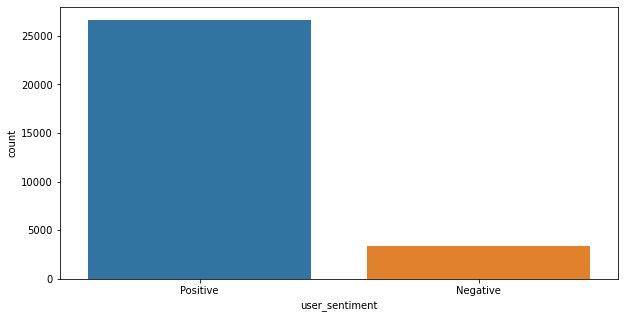

In [12]:
#plotting user_sentiment data distribution
plt.figure(figsize= (10,5))
sns.countplot(x='user_sentiment', data= df)
plt.show()

In [13]:
top_manufacturer = df['manufacturer'].value_counts().sort_values(ascending=False).head(10)
top_manufacturer

Clorox                    8546
Test                      3325
AmazonUs/CLOO7            2039
L'oreal Paris             1232
Walt Disney               1142
Burt's Bees                873
SONY CORP                  845
Twentieth Century Fox      757
P&G                        730
Nexxus Beauty Products     693
Name: manufacturer, dtype: int64

<AxesSubplot:>

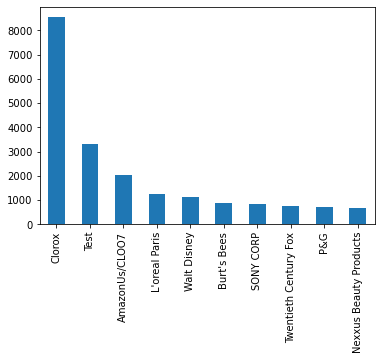

In [14]:
top_manufacturer.plot(kind='bar')

In [15]:
top_ratings = df['reviews_rating'].value_counts().sort_values(ascending=False)
top_ratings

5    20830
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

<AxesSubplot:>

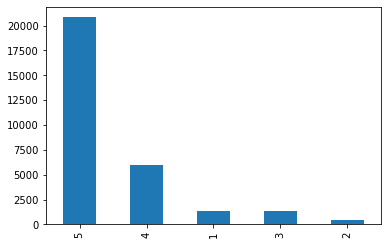

In [16]:
top_ratings.plot(kind='bar')

In [17]:
top_ratings.describe()

count        5.000000
mean      5999.800000
std       8573.829086
min        420.000000
25%       1345.000000
50%       1384.000000
75%       6020.000000
max      20830.000000
Name: reviews_rating, dtype: float64

## Re-usable methods

In [18]:
# Global Df for model summary
models_summary = pd.DataFrame()

In [19]:
# Method to get Summary of models
def summary_of_models(df) :
    global models_summary 
    models_summary = models_summary.append(df,ignore_index=True)

In [20]:
# Method to plot confusion matrix
def draw_confusion_matrix(cm):
    classes=['negative','positive']
    cmap=plt.cm.BuPu
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# Method to show different evaluation metrics 
from sklearn.metrics import precision_recall_fscore_support as score
#precision,recall,fscore,support=score(y_test,lr_prediction,average='macro')
def show_model_metrics(y_test,y_pred,model_name):
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    draw_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    precision,recall,fscore,support=score(y_test,lr_prediction,average='macro')
    
    data = [[model_name,accuracy,recall,precision,fscore]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','F1'])
    summary_of_models(df)
    return df 

### 1:Data Cleaning and Pre-Processing

In [22]:
# for sentiment analysis we need only below mentioned columns 
cols = ['id', 'name', 'reviews_rating', 'reviews_text', 'reviews_title','reviews_username', 'user_sentiment'] 
master_df = df[cols]
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29999 non-null  object
 1   name              29999 non-null  object
 2   reviews_rating    29999 non-null  int64 
 3   reviews_text      29999 non-null  object
 4   reviews_title     29809 non-null  object
 5   reviews_username  29936 non-null  object
 6   user_sentiment    29999 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB


In [23]:
# text and title are useful for anaysing sentiment so lets merge both columns into one
master_df['text_data'] = master_df['reviews_title'] + ' ' + master_df['reviews_text']
master_df.head()

<ipython-input-23-c3dbfc675071>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['text_data'] = master_df['reviews_title'] + ' ' + master_df['reviews_text']


,id,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,text_data
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Irritation My husband bought this gel for us. ...


In [24]:
# lets remove reviews text and title as we have merged them already
final_df = master_df.drop(columns=['reviews_text', 'reviews_title'])
final_df.head()

,id,name,reviews_rating,reviews_username,user_sentiment,text_data
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,Irritation My husband bought this gel for us. ...


In [25]:
# columns without missing values
final_df[~final_df.isnull()].count()

id                  29999
name                29999
reviews_rating      29999
reviews_username    29936
user_sentiment      29999
text_data           29809
dtype: int64

In [26]:
# percentage of missing values
100 - round(100*final_df[~final_df.isnull()].count()/len(final_df), 2)

id                  0.00
name                0.00
reviews_rating      0.00
reviews_username    0.21
user_sentiment      0.00
text_data           0.63
dtype: float64

In [27]:
# lets work on the data which is required for sentiment analysis
sentiment_df = final_df[['id', 'text_data', 'user_sentiment']]
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              29999 non-null  object
 1   text_data       29809 non-null  object
 2   user_sentiment  29999 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [28]:
#lets remvoe the null values from data frame
sentiment_df = sentiment_df.dropna()
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29809 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              29809 non-null  object
 1   text_data       29809 non-null  object
 2   user_sentiment  29809 non-null  object
dtypes: object(3)
memory usage: 931.5+ KB


In [29]:
# lets get the recommendation data frame 

recommendation_df = final_df[['id', 'reviews_rating', 'reviews_username']]
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29999 non-null  object
 1   reviews_rating    29999 non-null  int64 
 2   reviews_username  29936 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


### 2:Text Processing

In [30]:
# now lets perform the text preprocessing
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Just Awesome i love this album. it's very good...,Positive
1,AV14LG0R-jtxr-f38QfS,Good Good flavor. This review was collected as...,Positive
2,AV14LG0R-jtxr-f38QfS,Good Good flavor.,Positive
3,AV16khLE-jtxr-f38VFn,Disappointed I read through the reviews on her...,Negative
4,AV16khLE-jtxr-f38VFn,Irritation My husband bought this gel for us. ...,Negative


In [31]:
# convert the text to lower case
sentiment_df['user_sentiment'] = sentiment_df['user_sentiment'].apply(lambda x: str(x).lower())
sentiment_df['text_data'] = sentiment_df['text_data'].apply(lambda x: str(x).lower())
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,just awesome i love this album. it's very good...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor. this review was collected as...,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor.,positive
3,AV16khLE-jtxr-f38VFn,disappointed i read through the reviews on her...,negative
4,AV16khLE-jtxr-f38VFn,irritation my husband bought this gel for us. ...,negative


In [32]:
# remove special characters

def remove_punctuation(text):
    punc_chars = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
        if char not in punc_chars:
            no_punct = no_punct + char
    return no_punct

sentiment_df['text_data'] = sentiment_df['text_data'].apply(remove_punctuation)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,just awesome i love this album its very good m...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor this review was collected as ...,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappointed i read through the reviews on her...,negative
4,AV16khLE-jtxr-f38VFn,irritation my husband bought this gel for us t...,negative


In [33]:
# remove the numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

sentiment_df['text_data'] = sentiment_df['text_data'].apply(remove_numbers)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,just awesome i love this album its very good m...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor this review was collected as ...,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappointed i read through the reviews on her...,negative
4,AV16khLE-jtxr-f38VFn,irritation my husband bought this gel for us t...,negative


In [34]:
# Remvoe stop words & words with length 1
stop_words = stopwords.words('english') # get english stop words

def remove_singlechars(text):
    words = word_tokenize(text)
    valid_words = []
    for word in words:
        if len(word) > 1:
            valid_words.append(word)
    return " ".join(valid_words)

def remove_stopwords(text):
    words = word_tokenize(text)
    non_stop_words = []
    for word in words:
        if word not in stop_words:
            non_stop_words.append(word)
    return " ".join(non_stop_words)

In [35]:
sentiment_df['text_data'] = sentiment_df['text_data'].apply(remove_singlechars)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,just awesome love this album its very good mor...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor this review was collected as ...,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappointed read through the reviews on here ...,negative
4,AV16khLE-jtxr-f38VFn,irritation my husband bought this gel for us t...,negative


In [36]:
sentiment_df['text_data'] = sentiment_df['text_data'].apply(remove_stopwords)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,awesome love album good hip hop side current p...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor review collected part promotion,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappointed read reviews looking buying one c...,negative
4,AV16khLE-jtxr-f38VFn,irritation husband bought gel us gel caused ir...,negative


In [37]:
# perform stemming, lemmatization and spell correction
ws_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()
# spell = SpellChecker(distance=1)

# def spell_correction(text):
#   words = word_tokenize(text)
#   spell_words = [spell.correction(word) for word in words]
#   return " ".join(spell_words)

def stemming(text):
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words]
    return " ".join(stem_words)

def lemmatize(text):
    words = ws_tokenizer.tokenize(text)
    lemma_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemma_words)

In [38]:
# sentiment_df['text_data'] = sentiment_df['text_data'].apply(spell_correction)
# sentiment_df.head()
temp = sentiment_df.copy()

In [39]:
# lemmatization
sentiment_df['text_data'] = sentiment_df['text_data'].apply(lemmatize)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,awesome love album good hip hop side current p...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor review collected part promotion,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappointed read review looking buying one co...,negative
4,AV16khLE-jtxr-f38VFn,irritation husband bought gel u gel caused irr...,negative


In [40]:
# stemming the words
sentiment_df['text_data'] = sentiment_df['text_data'].apply(stemming)
sentiment_df.head()

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,awesom love album good hip hop side current po...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor review collect part promot,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappoint read review look buy one coupl lubr...,negative
4,AV16khLE-jtxr-f38VFn,irrit husband bought gel u gel caus irrit felt...,negative


In [41]:
# word cloud

def get_text(sentiment):
    data = sentiment_df[sentiment_df['user_sentiment'] == sentiment]
    return ' '.join(data['text_data'])

def generate_wordcloud(sentiment):
    words = get_text(sentiment)
    wordcloud = WordCloud(width = 800, height = 500,
                background_color ='black',
                min_font_size = 10).generate(words)
    # plot the WordCloud image                       
    plt.figure(figsize = (10, 15), facecolor = None)
    plt.imshow(wordcloud)  
    plt.show()

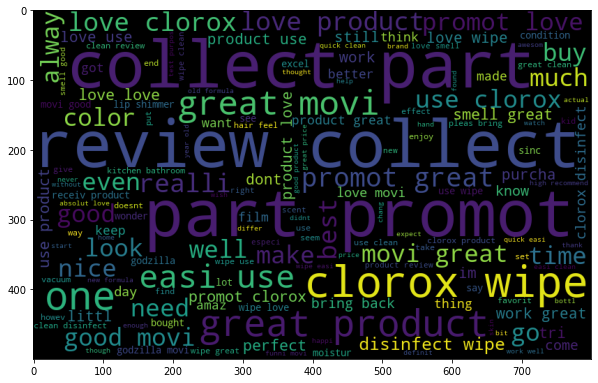

In [42]:
generate_wordcloud('positive')

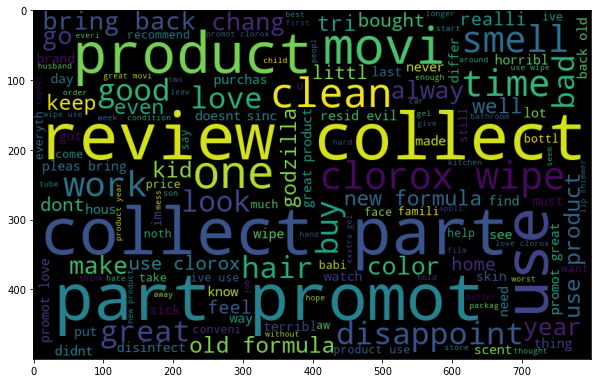

In [43]:
generate_wordcloud('negative')

### 3: Feature Extraction

In [44]:
# Extracting text features using tfidf vectorizer
tvec = TfidfVectorizer()
tvec.fit(sentiment_df['text_data'])
X_text = tvec.transform(sentiment_df['text_data'])

In [45]:
X_text.shape

(29809, 15368)

In [46]:
tvec.get_feature_names()[:10]

C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aaaaaaaaaaaaaaaaa',
 'aaaaahhhhhh',
 'aaahhhhh',
 'aaammmaaaz',
 'aalot',
 'aanyhwer',
 'aaron',
 'aarontaylor',
 'ab']

#### Splitting the data into train and test

In [47]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_text, sentiment_df['user_sentiment'], test_size=0.3)

In [48]:
# describes info about train and test set
print("Shape of X_train dataset: ", X_train.shape)
print("Shape of y_train dataset: ", y_train.shape)
print("Shape of X_test dataset: ", X_test.shape)
print("Shape of y_test dataset: ", y_test.shape)

Shape of X_train dataset:  (20866, 15368)
Shape of y_train dataset:  (20866,)
Shape of X_test dataset:  (8943, 15368)
Shape of y_test dataset:  (8943,)


***using SMOTE (Synthetic Minority Oversampling Technique) – Oversampling***

In [49]:
# as we know there is lot of imbalance between positives and negatives, we have to perform balancing.
# using SMOTE (Synthetic Minority Oversampling Technique) – Oversampling

In [50]:
print("Before OverSampling, counts of label 'positive': {}".format(sum(y_train == 'positive')))
print("Before OverSampling, counts of label 'negative': {} \n".format(sum(y_train == 'negative')))

sm = SMOTE(random_state = 0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label 'positive': {}".format(sum(y_train_res == 'positive')))
print("After OverSampling, counts of label 'negative': {}".format(sum(y_train_res == 'negative')))

Before OverSampling, counts of label 'positive': 18524
Before OverSampling, counts of label 'negative': 2342 

After OverSampling, the shape of X_train: (37048, 15368)
After OverSampling, the shape of y_train: (37048,) 

After OverSampling, counts of label 'positive': 18524
After OverSampling, counts of label 'negative': 18524


### 4: Model Building

In [51]:
# 1. Using logistic regression

In [52]:
# before over sampling
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())
lr_prediction = lr.predict(X_test)

print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

    negative       0.80      0.22      0.34      1003
    positive       0.91      0.99      0.95      7940

    accuracy                           0.91      8943
   macro avg       0.86      0.61      0.65      8943
weighted avg       0.90      0.91      0.88      8943



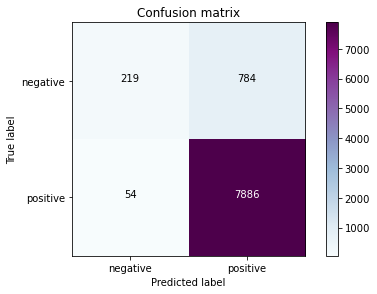

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404


In [53]:
# Model Performance
show_model_metrics(y_test, lr_prediction, "LR(Default)")

In [54]:
# after over sampling
lr_normal = LogisticRegression()
lr_normal.fit(X_train_res, y_train_res.ravel())
lr_prediction = lr_normal.predict(X_test)

print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

    negative       0.43      0.76      0.55      1003
    positive       0.97      0.87      0.92      7940

    accuracy                           0.86      8943
   macro avg       0.70      0.82      0.74      8943
weighted avg       0.91      0.86      0.88      8943



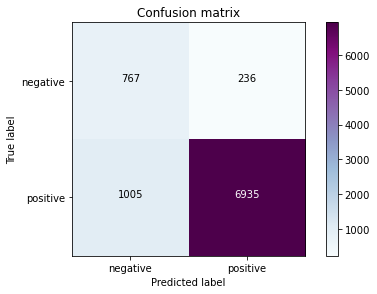

,Model,Accuracy,Precision,Recall,F1
0,LR(SMOTE),0.86,0.819066,0.699967,0.735334


In [55]:
# Model Performance
show_model_metrics(y_test, lr_prediction, "LR(SMOTE)")

In [56]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334


*We can see from above results the over sampled train data has produced a good model with good f1 score for negative sentiment along with good recall score*

In [57]:
# hyper parameter tuning for logistic regression
params = [
  {'penalty' : ['l2'],
  'C' : [100, 10, 1.0, 0.1, 0.01]}
]

grid_search = GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
                           param_grid=params, cv=5)
grid_search.fit(X_train_res, y_train_res.ravel())

print("Tuned Logistic Regression Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

Tuned Logistic Regression Parameters: {'C': 100, 'penalty': 'l2'}
Best score is 0.9393220340217947


In [58]:
# With best parameters
lr = LogisticRegression(C=100, penalty='l2', n_jobs=-1)
lr.fit(X_train_res, y_train_res.ravel())
lr_prediction = lr.predict(X_test)

print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

    negative       0.48      0.65      0.55      1003
    positive       0.95      0.91      0.93      7940

    accuracy                           0.88      8943
   macro avg       0.71      0.78      0.74      8943
weighted avg       0.90      0.88      0.89      8943



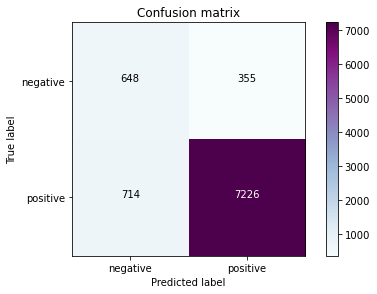

,Model,Accuracy,Precision,Recall,F1
0,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559


In [59]:
# Model Performance
show_model_metrics(y_test, lr_prediction, "LR(SMOTE)-Tuned")

In [60]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559


***There is not much difference in the f1/accuracy score of default and best parameter models. But the default model has good recall!!***

In [61]:
# 2. Random forest
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train_res, y_train_res.ravel())
rfc_prediction = rfc.predict(X_test)

print(classification_report(y_test, rfc_prediction))

              precision    recall  f1-score   support

    negative       0.57      0.38      0.46      1003
    positive       0.93      0.96      0.94      7940

    accuracy                           0.90      8943
   macro avg       0.75      0.67      0.70      8943
weighted avg       0.89      0.90      0.89      8943



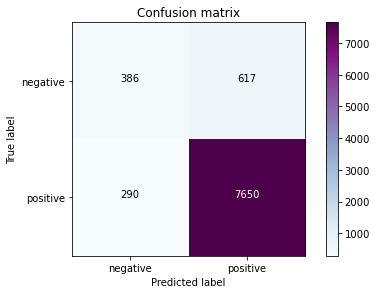

,Model,Accuracy,Precision,Recall,F1
0,RF(Default),0.9,0.778069,0.714472,0.739559


In [62]:
# Model Performance
show_model_metrics(y_test, rfc_prediction, "RF(Default)")

In [63]:
# lets do hyper parameter tuning 
params = [
  {
      'criterion': ['gini', 'entropy'],
      'n_estimators' : [100, 200],
      'max_depth' : [5, 10]}
]

grid_search = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                           param_grid=params, cv=3)
grid_search.fit(X_train_res, y_train_res.ravel())

print("Tuned RandomForestClassifier Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

Tuned RandomForestClassifier Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}
Best score is 0.814160970051283


In [64]:
# best parameters
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200, n_jobs=-1)
rfc.fit(X_train_res, y_train_res.ravel())
rfc_prediction = rfc.predict(X_test)

print(classification_report(y_test, rfc_prediction))

              precision    recall  f1-score   support

    negative       0.33      0.45      0.38      1003
    positive       0.93      0.88      0.91      7940

    accuracy                           0.84      8943
   macro avg       0.63      0.67      0.64      8943
weighted avg       0.86      0.84      0.85      8943



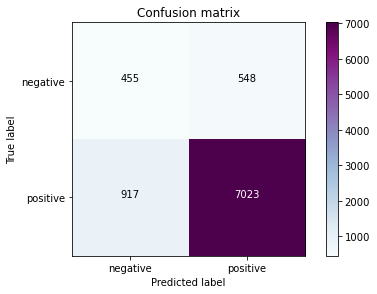

,Model,Accuracy,Precision,Recall,F1
0,RF(Tuned),0.84,0.778069,0.714472,0.739559


In [65]:
# Model Performance
show_model_metrics(y_test, rfc_prediction, "RF(Tuned)")

In [66]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559
3,RF(Default),0.90,0.778069,0.714472,0.739559
4,RF(Tuned),0.84,0.778069,0.714472,0.739559


***RandomForestClassifier has less f1 score specially for negative sentiments. Hence cannot be considered!***

In [67]:
# 3. XGBoost using decision tree

xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train_res, y_train_res.ravel())
xgb_predictions = xgb.predict(X_test)

print(classification_report(y_test, xgb_predictions))

C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    negative       0.49      0.58      0.53      1003
    positive       0.95      0.92      0.93      7940

    accuracy                           0.88      8943
   macro avg       0.72      0.75      0.73      8943
weighted avg       0.89      0.88      0.89      8943



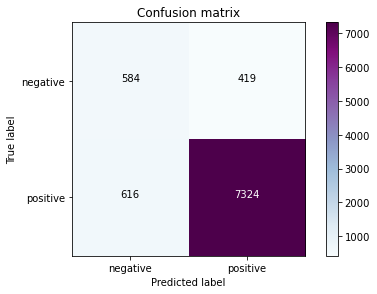

,Model,Accuracy,Precision,Recall,F1
0,XGB,0.88,0.778069,0.714472,0.739559


In [68]:
# Model Performance
show_model_metrics(y_test, xgb_predictions, "XGB")

In [69]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559
3,RF(Default),0.90,0.778069,0.714472,0.739559
4,RF(Tuned),0.84,0.778069,0.714472,0.739559
5,XGB,0.88,0.778069,0.714472,0.739559


***XGBClassifier has less f1 score specially for negative sentiments with default model iteself. Hence cannot be considered!***

In [70]:
# 4. Naive bayes
nb = MultinomialNB()

nb.fit(X_train_res, y_train_res.ravel())
nb_predictions = nb.predict(X_test)
 
print(classification_report(y_test, nb_predictions))

              precision    recall  f1-score   support

    negative       0.33      0.62      0.43      1003
    positive       0.95      0.84      0.89      7940

    accuracy                           0.82      8943
   macro avg       0.64      0.73      0.66      8943
weighted avg       0.88      0.82      0.84      8943



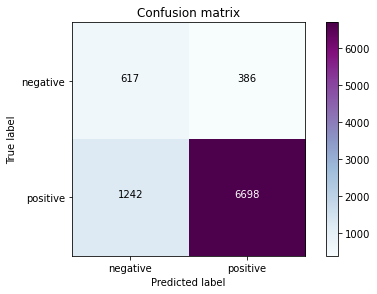

,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes,0.82,0.778069,0.714472,0.739559


In [71]:
# Model Performance
show_model_metrics(y_test, nb_predictions, "Naive Bayes")

In [72]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559
3,RF(Default),0.90,0.778069,0.714472,0.739559
4,RF(Tuned),0.84,0.778069,0.714472,0.739559
5,XGB,0.88,0.778069,0.714472,0.739559
6,Naive Bayes,0.82,0.778069,0.714472,0.739559


***MultinomialNB has less f1 score specially for negative sentiments with default model iteself. Hence cannot be considered!***

In [73]:
# 5. SGD classifier
sgd = SGDClassifier(n_jobs=-1)
sgd.fit(X_train_res, y_train_res.ravel())
sgd_predictions = sgd.predict(X_test)
 
print(classification_report(y_test, sgd_predictions))

              precision    recall  f1-score   support

    negative       0.41      0.79      0.54      1003
    positive       0.97      0.86      0.91      7940

    accuracy                           0.85      8943
   macro avg       0.69      0.82      0.73      8943
weighted avg       0.91      0.85      0.87      8943



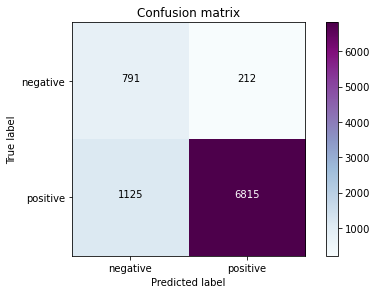

,Model,Accuracy,Precision,Recall,F1
0,SGD(Default),0.85,0.778069,0.714472,0.739559


In [74]:
# Model Performance
show_model_metrics(y_test, sgd_predictions, "SGD(Default)")

In [75]:
# lets do hyper parameter tuning 
params = [
  {
      'alpha': [0.0001, 0.001, 0.01],
      'max_iter' : [500, 1000, 1500]}
]
grid_search = GridSearchCV(estimator=SGDClassifier(n_jobs=-1),
                           param_grid=params, cv=3)
grid_search.fit(X_train_res, y_train_res.ravel())

print("Tuned SGDClassifier Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

Tuned SGDClassifier Parameters: {'alpha': 0.0001, 'max_iter': 1000}
Best score is 0.9046103379567415


In [76]:
# model with best hyper parameters
sgd = SGDClassifier(alpha=0.0001, max_iter=1500, n_jobs=-1)
sgd.fit(X_train_res, y_train_res.ravel())
sgd_predictions = sgd.predict(X_test)
 
print(classification_report(y_test, sgd_predictions))

              precision    recall  f1-score   support

    negative       0.41      0.79      0.54      1003
    positive       0.97      0.86      0.91      7940

    accuracy                           0.85      8943
   macro avg       0.69      0.82      0.72      8943
weighted avg       0.91      0.85      0.87      8943



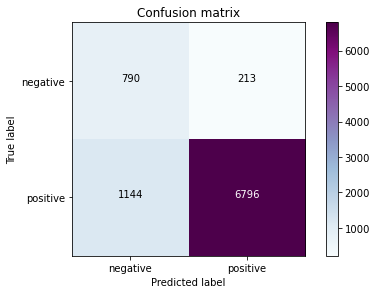

,Model,Accuracy,Precision,Recall,F1
0,SGD(Tuned),0.85,0.778069,0.714472,0.739559


In [77]:
# Model Performance
show_model_metrics(y_test, sgd_predictions, "SGD(Tuned)")

In [78]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559
3,RF(Default),0.90,0.778069,0.714472,0.739559
4,RF(Tuned),0.84,0.778069,0.714472,0.739559
5,XGB,0.88,0.778069,0.714472,0.739559
6,Naive Bayes,0.82,0.778069,0.714472,0.739559
7,SGD(Default),0.85,0.778069,0.714472,0.739559
8,SGD(Tuned),0.85,0.778069,0.714472,0.739559


***SGDClassifier has performed better in comparision with other models but it's f1 score is less as compared to Logistic regression model. As the Logistic regression is quiet simpler, will choose LR model over SGD!!***

In [79]:
# 6. Linear SVC
svc = LinearSVC()
svc.fit(X_train_res, y_train_res.ravel())
svc_predictions = svc.predict(X_test)
 
print(classification_report(y_test, svc_predictions))

              precision    recall  f1-score   support

    negative       0.47      0.70      0.56      1003
    positive       0.96      0.90      0.93      7940

    accuracy                           0.88      8943
   macro avg       0.71      0.80      0.75      8943
weighted avg       0.90      0.88      0.89      8943



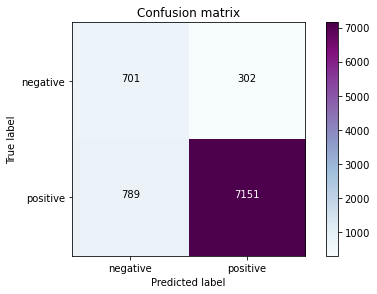

,Model,Accuracy,Precision,Recall,F1
0,LinearSVC,0.88,0.778069,0.714472,0.739559


In [80]:
# Model Performance
show_model_metrics(y_test, svc_predictions, "LinearSVC")

In [81]:
models_summary

,Model,Accuracy,Precision,Recall,F1
0,LR(Default),0.91,0.605772,0.855886,0.646404
1,LR(SMOTE),0.86,0.819066,0.699967,0.735334
2,LR(SMOTE)-Tuned,0.88,0.778069,0.714472,0.739559
3,RF(Default),0.90,0.778069,0.714472,0.739559
4,RF(Tuned),0.84,0.778069,0.714472,0.739559
5,XGB,0.88,0.778069,0.714472,0.739559
6,Naive Bayes,0.82,0.778069,0.714472,0.739559
7,SGD(Default),0.85,0.778069,0.714472,0.739559
8,SGD(Tuned),0.85,0.778069,0.714472,0.739559
9,LinearSVC,0.88,0.778069,0.714472,0.739559


**Again Linear SVC is underperformed as compared to Logistic regression, so we will choose Logistic Regression**

### 5: Building the Recommendation System

In [82]:
# use the recommendation dataframe
recommendation_df.head()

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


In [83]:
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29999 non-null  object
 1   reviews_rating    29999 non-null  int64 
 2   reviews_username  29936 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [84]:
# as the missing percentage of username is less, let's drop them
recommendation_df = recommendation_df.dropna()
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29936 non-null  object
 1   reviews_rating    29936 non-null  int64 
 2   reviews_username  29936 non-null  object
dtypes: int64(1), object(2)
memory usage: 935.5+ KB


***Dividing the dataset into train and test***

In [85]:
train, test = train_test_split(recommendation_df, test_size= 0.3, random_state=42)

In [86]:
print(train.shape)
print(test.shape)

(20955, 3)
(8981, 3)


In [87]:
# create pivot matrix table in which columns are products and rows are users
df_pivot = train.reset_index().pivot_table( index='reviews_username', columns='id',values='reviews_rating', aggfunc='mean').fillna(0)
df_pivot.head(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# creating dummy train and test 
dummy_train = train.copy()
dummy_train.head(5)

,id,reviews_rating,reviews_username
20944,AVpfM_ytilAPnD_xXIJb,5,speede
962,AV1YGDqsGV-KLJ3adc-O,5,brittney w
10463,AVpf3VOfilAPnD_xjpun,5,cjshrad
25385,AVpfPaoqLJeJML435Xk9,5,zman69
27096,AVpfrFDZLJeJML43Bmv0,5,misunshyne


In [89]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [90]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.reset_index().pivot_table(index='reviews_username', columns='id',values='reviews_rating', aggfunc='mean').fillna(1)
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Using cosine similarity

In [91]:
df_pivot.index.nunique()

18273

In [92]:
# create user similarity matrix
user_similarity = 1 - pairwise_distances(df_pivot, metric='cosine')
user_similarity[np.isnan(user_similarity)] = 0
user_similarity

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [93]:
user_similarity.shape

(18273, 18273)

In [94]:
# Using adjusted Cosine
# Here, we are not removing the NaN values and calculating the mean only for the products rated by the user
# Create a user-product matrix.
df_pivot = train.reset_index().pivot_table(index='reviews_username', columns='id',values='reviews_rating', aggfunc='mean')
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# Normalising the review rating of the product for each user around 0 mean

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T - mean).T
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [97]:
user_correlation.shape

(18273, 18273)

### User - User prediction

In [98]:
# make negative values to zero
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
# Rating predicted by the user (for products rated as well as not rated)
# is the weighted sum of correlation with the product rating (as present in the rating dataset).
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 0.        ,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [100]:
user_predicted_ratings.shape

(18273, 256)

In [101]:
# Since we are interested only in the products not rated by the user, 
# we will ignore the products rated by the user by making it zero. 
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,0.944911,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,0.0,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


***Evaluation - User-user***

In [102]:
 # Find out the common users of test and train dataset.
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

(2049, 3)

In [103]:
common_users.head()

,id,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,5,jessica
21657,AVpfm8yiLJeJML43AYyu,1,romance318
23320,AVpfPaoqLJeJML435Xk9,3,countprice
21505,AVpfm8yiLJeJML43AYyu,1,farbar
28265,AVpfRTh1ilAPnD_xYic2,5,mimi


In [104]:
# create pivot table for common users
common_users_pivot = common_users.reset_index().pivot_table(index='reviews_username',
                                                            columns='id',
                                                            values='reviews_rating',
                                                            aggfunc='mean')
common_users_pivot.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# set userid as index
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
common_users.head()

,id,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,5,jessica
21657,AVpfm8yiLJeJML43AYyu,1,romance318
23320,AVpfPaoqLJeJML435Xk9,3,countprice
21505,AVpfm8yiLJeJML43AYyu,1,farbar
28265,AVpfRTh1ilAPnD_xYic2,5,mimi


In [108]:
list_name = common_users.reviews_username.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1694, 18273)

In [109]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,aac06002,aalyah,aaron,...,wren113,xavier,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
user_correlation_df_3.shape

(1694, 1694)

In [111]:
# replace negative values with zero
user_correlation_df_3[user_correlation_df_3 < 0] = 0

In [112]:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_users_pivot.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
dummy_test = common_users.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean').fillna(0)
dummy_test.shape

(1694, 139)

In [114]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
# Calculating the RMSE for only the products rated by user, normalizing the rating to (1,5) range.
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))

C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [117]:
common_ = common_users.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean')

In [118]:
# Finding total non-NaN value
non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/non_nan)**0.5
print(rmse)

2.553499231423454


***Item-item Similarity***

In [119]:
# Item based similarity
df_pivot = train.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean').T
df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Normalising the product rating for each product for using the Adujsted Cosine

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T - mean).T
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [122]:
item_correlation.shape

(256, 256)

In [123]:
# Replacing the -ve correlation with 0

item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [124]:
# Prediction on item-item
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00608031, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00966745],
       [0.        , 0.        , 0.        , ..., 0.00791544, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00773396]])

In [125]:
item_predicted_ratings.shape

(18273, 256)

In [126]:
dummy_train.shape

(18273, 256)

In [127]:
# Filtering the rating only for the products not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006042,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.020509,0.00608,0.0,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.097395,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.162325,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.129860,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000082,0.0,0.0,0.0,0.001244,0.002197,0.001808,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.006084,0.00000,0.0,0.009667


***Evaluation - item-item***

In [128]:
common =  test[test.id.isin(train.id)]
common.shape

(8965, 3)

In [129]:
common.head()

,id,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,5,ashleydale00
15778,AVpf63aJLJeJML43F__Q,3,angie1108
1138,AV1YmDL9vKc47QAVgr7_,5,falisha
12875,AVpf3VOfilAPnD_xjpun,5,jessica


In [130]:
common_item_based_matrix = common.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean').T
common_item_based_matrix.shape

(195, 8321)

In [131]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

In [133]:
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.108098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
item_correlation_df_3[item_correlation_df_3<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.66745425e-03]])

In [135]:
common_item_predicted_ratings.shape

(195, 8321)

In [136]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >= 1 else 0)

In [137]:
dummy_test = dummy_test.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [138]:
# The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.
common_ = common.reset_index().pivot_table(values='reviews_rating', index='reviews_username', columns='id', aggfunc='mean').T

In [139]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)

C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\NIRMAL KUMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(feature_range=(1, 5))

In [140]:
y = (scaler.transform(X))
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan,  1., nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [141]:
# Finding total non-NaN value
non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/non_nan)**0.5
print(rmse)

3.5662663642070407


***Since the RMSE of User-User (2.55) is lower than Item-Item (3.56). Hence we will use 'User-User' model from Recommendation***

In [142]:
# Among all the models Logistic regression model is better one as per the recall and f1 score
lr_file = open('Sentiment_model.pkl', 'ab')
pickle.dump(lr_normal, lr_file)
lr_file.close()

In [143]:
# Saving tfidf vector object
vec_file = open('tfidf_vectorizer.pkl', 'ab')
pickle.dump(tvec, vec_file)
vec_file.close()

In [144]:
# pickelling the important vectors and models
user_file = open('user_recommendation.pkl', 'ab')
pickle.dump(user_final_rating, user_file)
user_file.close()

In [145]:
# saving the clean sentiment data frame for prediction purpose
sentiment_df.to_csv('sentiment_df.csv')

### 6: Recommendation of Top 20 Products to a Specified User

In [146]:
# Finding the top recommendation for user 00sab00 with positive sentiments
user_input = "00sab00"

In [147]:
# get top 20 product id's
product_ids = user_final_rating.loc[user_input].sort_values(ascending=False)[:20]
product_ids.head()

id
AVpfPaoqLJeJML435Xk9    38.627630
AVpfRTh1ilAPnD_xYic2    30.740200
AVpf0eb2LJeJML43EVSt    14.343519
AVpf3VOfilAPnD_xjpun    12.240570
AVpf2tw1ilAPnD_xjflC    11.178377
Name: 00sab00, dtype: float64

In [148]:
# map the product with its id's
product_map = pd.DataFrame(df[['id','name']]).drop_duplicates()
product_map.head()

,id,name
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar


In [149]:
products = pd.merge(product_ids, product_map, on='id')
products['name'].head(20)

0     Godzilla 3d Includes Digital Copy Ultraviolet ...
1     Planes: Fire Rescue (2 Discs) (includes Digita...
2        The Resident Evil Collection 5 Discs (blu-Ray)
3     Clorox Disinfecting Wipes Value Pack Scented 1...
4                      Red (special Edition) (dvdvideo)
5     Coty Airspun Face Powder, Translucent Extra Co...
6                     Tostitos Bite Size Tortilla Chips
7                                Hormel Chili, No Beans
8                        Jason Aldean - They Don't Know
9       Bisquick Original Pancake And Baking Mix - 40oz
10                                Alex Cross (dvdvideo)
11    Stargate (ws) (ultimate Edition) (director's C...
12    Windex Original Glass Cleaner Refill 67.6oz (2...
13                  100:Complete First Season (blu-Ray)
14    Just For Men Touch Of Gray Gray Hair Treatment...
15                 Clorox Disinfecting Bathroom Cleaner
16    Pendaflex174 Divide It Up File Folder, Multi S...
17    Caress Moisturizing Body Bar Natural Silk,

***Above are the top 20 recommended products by using only the recommendation model/table***

### 7: Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [150]:
# get the sentiment dataframe
sentiment_df[['id', 'text_data', 'user_sentiment']]

,id,text_data,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,awesom love album good hip hop side current po...,positive
1,AV14LG0R-jtxr-f38QfS,good good flavor review collect part promot,positive
2,AV14LG0R-jtxr-f38QfS,good good flavor,positive
3,AV16khLE-jtxr-f38VFn,disappoint read review look buy one coupl lubr...,negative
4,AV16khLE-jtxr-f38VFn,irrit husband bought gel u gel caus irrit felt...,negative
...,...,...,...
29995,AVpfW8y_LJeJML437ySW,soft got condition influenst tri im love far o...,positive
29996,AVpfW8y_LJeJML437ySW,love love receiv review purpos influenst leaf ...,positive
29997,AVpfW8y_LJeJML437ySW,hair smooth use first love smell product wash ...,positive
29998,AVpfW8y_LJeJML437ySW,perfect oili hair receiv influenst never go ba...,positive


In [151]:
# Mapping product with product reviews
product_mapping_review = pd.DataFrame(sentiment_df[['id','text_data','user_sentiment']]).drop_duplicates()
product_review_data =pd.merge(products, product_mapping_review, on='id')
product_review_data

,id,00sab00,name,text_data,user_sentiment
0,AVpfPaoqLJeJML435Xk9,38.627630,Godzilla 3d Includes Digital Copy Ultraviolet ...,aw could left one shelf great box,positive
1,AVpfPaoqLJeJML435Xk9,38.627630,Godzilla 3d Includes Digital Copy Ultraviolet ...,much wors expect movi much wors expect broderi...,positive
2,AVpfPaoqLJeJML435Xk9,38.627630,Godzilla 3d Includes Digital Copy Ultraviolet ...,dont get hype dont get hype godzilla frank mov...,negative
3,AVpfPaoqLJeJML435Xk9,38.627630,Godzilla 3d Includes Digital Copy Ultraviolet ...,best item littl disappoint like godzilla movi ...,negative
4,AVpfPaoqLJeJML435Xk9,38.627630,Godzilla 3d Includes Digital Copy Ultraviolet ...,good movi bad packag sale bought got case brok...,negative
...,...,...,...,...,...
18127,AVpfKOYiilAPnD_xWOFw,2.886751,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",love smell ive use product quit time love grea...,positive
18128,AVpfKOYiilAPnD_xWOFw,2.886751,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",amaz great scent,positive
18129,AVpfKOYiilAPnD_xWOFw,2.886751,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",love love bodi butter smell incred remind vaca...,positive
18130,AVpfKOYiilAPnD_xWOFw,2.886751,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",rich creami love rich delici smell great bodi ...,positive


In [152]:
# get the feature vectors
tfidf_features = tvec.transform(product_review_data['text_data'])

In [153]:
# Predict Sentiment Score on the above Product Reviews using the finally selected ML model 
# i.e. Logistic regression
product_review_data['predicted_sentiment'] = lr_normal.predict(tfidf_features)

In [154]:
# print the classification report 
print(classification_report(product_review_data['user_sentiment'], product_review_data['predicted_sentiment']))

              precision    recall  f1-score   support

    negative       0.47      0.85      0.61      1845
    positive       0.98      0.89      0.93     16287

    accuracy                           0.89     18132
   macro avg       0.73      0.87      0.77     18132
weighted avg       0.93      0.89      0.90     18132



In [155]:
product_review_data.head()

,id,00sab00,name,text_data,user_sentiment,predicted_sentiment
0,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,aw could left one shelf great box,positive,negative
1,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,much wors expect movi much wors expect broderi...,positive,positive
2,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,dont get hype dont get hype godzilla frank mov...,negative,negative
3,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,best item littl disappoint like godzilla movi ...,negative,negative
4,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,good movi bad packag sale bought got case brok...,negative,negative


In [156]:
# compute the sentiment score
product_review_data['predicted_sentiment_score'] = product_review_data['predicted_sentiment'].replace(['negative','positive'],[0,1])
product_review_data.head()

,id,00sab00,name,text_data,user_sentiment,predicted_sentiment,predicted_sentiment_score
0,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,aw could left one shelf great box,positive,negative,0
1,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,much wors expect movi much wors expect broderi...,positive,positive,1
2,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,dont get hype dont get hype godzilla frank mov...,negative,negative,0
3,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,best item littl disappoint like godzilla movi ...,negative,negative,0
4,AVpfPaoqLJeJML435Xk9,38.62763,Godzilla 3d Includes Digital Copy Ultraviolet ...,good movi bad packag sale bought got case brok...,negative,negative,0


In [157]:
# Find positive sentiment percentage for every product
product_pivot = product_review_data.reset_index().pivot_table(values='predicted_sentiment_score', index='name', aggfunc='mean')
product_pivot.sort_values(by='predicted_sentiment_score',inplace= True, ascending= False)
product_pivot.head()

,predicted_sentiment_score
name,
Red (special Edition) (dvdvideo),0.934426
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),0.908602
100:Complete First Season (blu-Ray),0.890511
Clorox Disinfecting Bathroom Cleaner,0.873232
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.862676


In [158]:
## END